✅ 所有库导入完成。
正在下载数据...（首次运行需要下载，请稍等）
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
✅ 数据加载成功！
<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: [

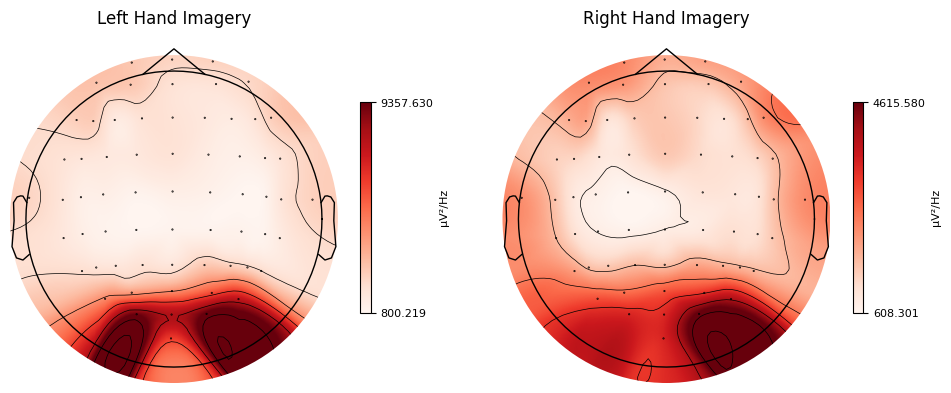

✅ 左右手运动想象的Mu节律地形图对比完成！
提示：对比观察两侧C3和C4电极区域的色彩差异。
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)


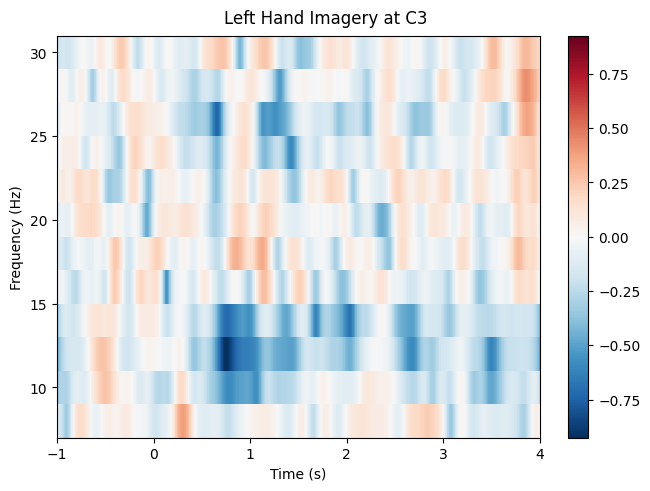

Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (data): 63
    data: rank 63 computed from 64 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 64 -> 63
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
    Setting small data eigenvalues to zero (without PCA)
🔬 最佳参数: {'csp__n_components': 2}
🏆 最佳交叉验证准确率: 66.67%


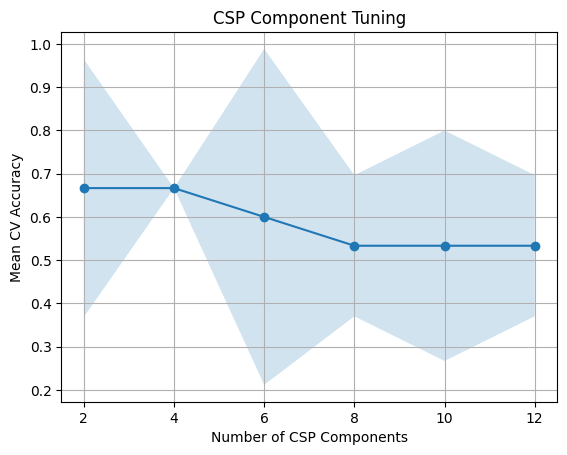

🤖 【SVM分类器】交叉验证准确率: 53.33% (+/- 32.66%)


In [ ]:
# 1. 安装MNE库（Colab通常已预装，但确保最新版）
!pip install -U mne

## 1. 基础科学计算与数据处理库
import numpy as np
import matplotlib.pyplot as plt

# 2. MNE库 (EEG处理核心)
import mne
from mne.datasets import eegbci
from mne.decoding import CSP  # 【关键修正】CSP在这里导入
from mne.time_frequency import tfr_morlet

# 3. Scikit-learn库 (机器学习核心)
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

print("✅ 所有库导入完成。")
# ... 你后面的数据加载和分析代码 ...

print("正在下载数据...（首次运行需要下载，请稍等）")
print("="*60)

# 1. 加载同一被试（Subject 1）的多次运动想象实验
raw_files = eegbci.load_data(subjects=[1], runs=[4, 8, 12]) # Runs 4,8,12都是左右手想象
raw_list = [mne.io.read_raw_edf(f, preload=True) for f in raw_files]
raw = mne.concatenate_raws(raw_list) # 合并为一个Raw对象
mne.datasets.eegbci.standardize(raw)

# 2. 重复后续所有预处理步骤（滤波、重参考、设置Montage等）
# ... [此处插入你完整的预处理和Epochs创建代码] ...

# 3. 重新绘制地形图对比和时频图，观察结果是否变得清晰。
# 3. 标准化通道名称
mne.datasets.eegbci.standardize(raw)
raw.set_montage('standard_1020') # 设置标准电极位置，便于后续绘图

# 4. 查看数据集核心信息
print("✅ 数据加载成功！")
print("="*60)
print(raw.info) # 最全面的信息摘要
print("-" * 50)
print(f'通道名称: {raw.ch_names}') # 查看所有通道
print(f'采样频率: {raw.info["sfreq"]} Hz') # 【修正】key是'sfreq'，不是'srefq'
print(f'数据形状: {raw.get_data().shape}') # (通道数, 时间点数)
print(f'记录时长: {raw.times[-1]:.2f} 秒') # 数据总时长

# 步骤 2：重新加载你的数据（因为环境重置后，之前加载的数据变量也丢失了）
from mne.datasets import eegbci
raw_file_paths = eegbci.load_data(subjects=[1], runs=[4])
raw = mne.io.read_raw_edf(raw_file_paths[0], preload=True)
mne.datasets.eegbci.standardize(raw)

# 步骤 3：进行你之前成功的预处理（滤波、重参考）
raw_filtered = raw.copy().filter(7.0, 30.0, fir_design='firwin', picks='eeg')
raw_filtered.set_eeg_reference('average')
# 【！！！关键添加！！！】设置标准电极位置，这是绘制地形图所必需的
raw_filtered.set_montage('standard_1020') # 添加这一行
print("✅ 已设置标准10-20系统电极位置。")
# 步骤 4：提取事件并创建Epochs（修正了event_id的语法）
events, event_dict = mne.events_from_annotations(raw_filtered)
print("找到的事件标记对应关系:", event_dict)

# 【关键修正】 event_id 应该是一个字典，使用花括号 {}
epochs = mne.Epochs(raw_filtered, events,
                    event_id={'left': event_dict['T1'], 'right': event_dict['T2']}, # 注意是 {}
                    tmin=-1, tmax=4, baseline=(-1, 0), preload=True)
print(f"创建了 {len(epochs['left'])} 个左手试次 和 {len(epochs['right'])} 个右手试次")
# 步骤 5：计算功率谱密度并绘制地形图 (使用正确的 `bands` 参数)
print("\n🎨 正在绘制频谱地形图...")
# 1. 计算左手和右手想象数据的功率谱
psd_left = epochs['left'].compute_psd()
psd_right = epochs['right'].compute_psd()

# 2. 创建并排子图 (1行，2列)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 3. 绘制左手想象的地形图（固定在左侧子图）
psd_left.plot_topomap(bands=[(8, 12, 'Mu (8-12Hz)')],
                      axes=axes[0], show=False)
axes[0].set_title('Left Hand Imagery')  # 设置子图标题

# 4. 绘制右手想象的地形图（固定在右侧子图）
psd_right.plot_topomap(bands=[(8, 12, 'Mu (8-12Hz)')],
                       axes=axes[1], show=False)
axes[1].set_title('Right Hand Imagery')

# 5. 自动调整布局并显示
plt.tight_layout()
plt.show()

print("✅ 左右手运动想象的Mu节律地形图对比完成！")
print("提示：对比观察两侧C3和C4电极区域的色彩差异。")
# 在C3和C4通道上分别计算并绘制时频图
freqs = np.arange(8, 31, 2)  # 频率从8到30Hz
n_cycles = freqs / 2.  # 设置小波周期
power_left = mne.time_frequency.tfr_morlet(epochs['left'], freqs=freqs, n_cycles=n_cycles, picks='C3', return_itc=False, average=True)
power_left.plot(picks='C3', baseline=(-1, 0), mode='logratio', title='Left Hand Imagery at C3')
# 1. 准备数据和标签（假设你已有epochs对象）
X = epochs.get_data()  # 形状: (试次数, 通道数, 时间点数)
y = epochs.events[:, -1]  # 获取原始事件标签 (如T1, T2)
# 将T1/T2标签映射为0/1
y_binary = np.array([0 if label == event_dict['T1'] else 1 for label in y])


# 1. 创建数据处理管道（标准化 + CSP + LDA）
pipe = make_pipeline(
    CSP(reg=None, log=True, norm_trace=False),
    StandardScaler(),
    LDA()
)
# 定义参数网格：重点搜索最佳组件数
param_grid = {
    'csp__n_components': [2, 4, 6, 8, 10, 12]  # 尝试多种数量
}

# 执行网格搜索交叉验证
grid_search = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y_binary)

print(f"🔬 最佳参数: {grid_search.best_params_}")
print(f"🏆 最佳交叉验证准确率: {grid_search.best_score_:.2%}")

# 可视化不同组件数的性能
import matplotlib.pyplot as plt
results = grid_search.cv_results_
plt.figure()
plt.plot(param_grid['csp__n_components'], results['mean_test_score'], 'o-')
plt.fill_between(param_grid['csp__n_components'],
                 results['mean_test_score'] - results['std_test_score'],
                 results['mean_test_score'] + results['std_test_score'],
                 alpha=0.2)
plt.xlabel('Number of CSP Components')
plt.ylabel('Mean CV Accuracy')
plt.title('CSP Component Tuning')
plt.grid(True)
plt.show()
# 2. 使用最优CSP组件数（2个）构建SVM管道
best_n_comp = 2  # 根据你的网格搜索结果

svm_pipeline = make_pipeline(
    CSP(n_components=best_n_comp, reg=None, log=True, norm_trace=False),
    StandardScaler(),
    SVC(kernel='linear', random_state=42, C=1.0)  # 线性核SVM，C是正则化参数
)

# 3. 使用相同的5折交叉验证评估SVM
svm_scores = cross_val_score(svm_pipeline, X, y_binary,
                             cv=StratifiedKFold(5, shuffle=True, random_state=42),
                             scoring='accuracy',
                             n_jobs=-1)
print(f'🤖 【SVM分类器】交叉验证准确率: {svm_scores.mean():.2%} (+/- {svm_scores.std()*2:.2%})')

In [9]:
# 1. 安装MNE库（Colab通常已预装，但确保最新版）
!pip install -U mne
import numpy as np
import mne
from mne.datasets import eegbci
from mne.decoding import CSP
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_subject_data(subject_id, runs=[4, 8, 12]):
    """为指定被试加载数据并预处理，返回 epochs"""
    # 加载
    raw_files = eegbci.load_data(subjects=[subject_id], runs=runs)
    raw_list = [mne.io.read_raw_edf(f, preload=True) for f in raw_files]
    raw = mne.concatenate_raws(raw_list)
    mne.datasets.eegbci.standardize(raw)
    # 预处理（使用与你之前完全相同的参数）
    raw_filtered = raw.copy().filter(7.0, 30.0, fir_design='firwin', picks='eeg')
    raw_filtered.set_eeg_reference('average')
    raw_filtered.set_montage('standard_1020')
    # 创建epochs
    events, event_dict = mne.events_from_annotations(raw_filtered)
    epochs = mne.Epochs(raw_filtered, events,
                        event_id={'left': event_dict['T1'], 'right': event_dict['T2']},
                        tmin=-1, tmax=4, baseline=(-1, 0), preload=True)
    return epochs, event_dict

# 1. 合并数据
print("开始加载并合并多个被试的数据...")
all_epochs = []
all_labels = []

for subj in [1, 2, 3, 4]:  # 合并前4名被试
    print(f"  处理被试 {subj}...")
    epochs_sub, event_dict_sub = get_subject_data(subj)
    all_epochs.append(epochs_sub)
    # 为每个试次生成标签：左手为0，右手为1
    labels_sub = (epochs_sub.events[:, -1] == event_dict_sub['T2']).astype(int)
    all_labels.append(labels_sub)

# 合并
epochs_all = mne.concatenate_epochs(all_epochs)
y_all = np.concatenate(all_labels)
X_all = epochs_all.get_data()

print(f"\n✅ 数据合并完成！总试次数: {len(epochs_all)}")
print(f"   标签分布: {np.unique(y_all, return_counts=True)}")

# 2. 评估性能
pipeline = make_pipeline(
    CSP(n_components=4, reg=None, log=True, norm_trace=False),  # 可增加组件数
    StandardScaler(),
    LDA()
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X_all, y_all, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"\n📊 【多被试模型】交叉验证准确率: {scores.mean():.2%} (+/- {scores.std()*2:.2%})")
print(f"   详细得分: {scores}")

开始加载并合并多个被试的数据...
  处理被试 1...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB sto

Download complete in 18s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R04.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R08.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R12.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB

Download complete in 17s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R04.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R08.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R12.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB

Download complete in 17s (7.3 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R04.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R08.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R12.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB

/tmp/ipython-input-1203431538.py:44: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_all = mne.concatenate_epochs(all_epochs)



✅ 数据合并完成！总试次数: 180
   标签分布: (array([0, 1]), array([92, 88]))

📊 【多被试模型】交叉验证准确率: 44.44% (+/- 16.85%)
   详细得分: [0.38888889 0.58333333 0.38888889 0.36111111 0.5       ]
